In [1]:
import pandas as pd
import numpy as np
import urllib2
import collections
import json
import bs4
import datetime
import re
import time
import wptools
import os
import scipy
import scipy.stats
from fuzzywuzzy import process
import matplotlib.pyplot as plt

In [2]:
!ls


Dunk Dataset.ipynb      database.pyc            player_dunk_summary.csv
__pycache__             dunk.db                 processed
annotate.ipynb          dunk_summary.csv        scraper.py
annotate.py             dunks.db                scraper.pyc
assemble.py             fix_dunks.sql           team_dunk_summary.csv
data                    parser.py               test_parser.py
database.py             parser.pyc              test_scraper.py


In [6]:
with open(os.path.join('data','2012', 'pbp_reg', 'pbp_400277721.txt'), 'r') as f:
    print f.read()

<!DOCTYPE html>
<html class="no-icon-fonts">
<head>
<meta content="text/html; charset=utf-8" http-equiv="content-type"/>
<meta content="IE=edge,chrome=1" http-equiv="x-ua-compatible"/>
<meta content="initial-scale=1.0, maximum-scale=1.0, user-scalable=no" name="viewport"/>
<link href="http://www.espn.com/nba/playbyplay?gameId=400277721" rel="canonical"/>
<title>Wizards vs. Cavaliers - Play-By-Play - October 30, 2012 - ESPN</title>
<meta content="Get play-by-play updates on the Washington Wizards vs. Cleveland Cavaliers basketball game." name="description"/>
<meta content="" name="news_keywords"/>
<meta content="" name="keywords"/>
<meta content="116656161708917" property="fb:app_id"/>
<meta content="ESPN.com" property="og:site_name"/>
<meta content="http://www.espn.com/nba/playbyplay?gameId=400277721" property="og:url"/>
<meta content="Wizards vs. Cavaliers - Play-By-Play - October 30, 2012 - ESPN" property="og:title"/>
<meta content="Get play-by-play updates on the Washington Wizards 

In [833]:
def parse_player_page(page):
    table = bs4.BeautifulSoup(page, "lxml").find("div", {"id":"div_totals_stats"}).table
    stat_dict = collections.defaultdict(list)
    for row in table.find_all("tr", {"class":["full_table", "partial_table"]})[1:]:
        if row.find("td")["data-append-csv"] not in stat_dict["player_id"]:

            for col in row.find_all("td"):
                if col.has_attr("data-stat"):
                    stat_name = col["data-stat"]

                    # Special behavior for managing team data
                    if stat_name == "team_id":
                        if col.text != "TOT":
                            #this player played on just one team this season.
                            stat_dict["teams"].append([col.text])
                        else:
                            #this player played on multiple teams, we'll add them later.
                            stat_dict["teams"].append([])
                    # Special behavior for the player name data
                    elif stat_name == "player":
                        player = col["csk"]
                        stat_dict["first_name"].append(player.split(",")[1])
                        stat_dict["last_name"].append(player.split(",")[0])
                        stat_dict["player_id"].append(col["data-append-csv"])
                    # With everything else just use the stat name
                    else:
                        stat_dict[stat_name].append(col.text)
        else:
            # we've recorded this player's information before, we just need to complete his list of teams.
            index = stat_dict["player_id"].index(row.find("td")["data-append-csv"])
            stat_dict["teams"][index].append(row.find("td", {"data-stat":"team_id"}).a.text)
    df = pd.DataFrame(stat_dict)
    return df

In [57]:
def request_players_from_web(year):
    player_stat_page = "http://www.basketball-reference.com/leagues/NBA_{0}_totals.html".format(str(year+1))
    r = urllib2.urlopen(player_stat_page)
    return r

In [58]:
def request_and_parse_players_for_year(year, force_query=False):
    
    def backup_players_to_disk(year, df):
        if not os.path.exists(str(year)):
            os.makedirs(str(year))
            
        with open(os.path.join(str(year),"player_list.csv"), "w") as f:
            df.to_csv(f)
    
    if force_query:
        # We want to get the remote copy, regardless if we have it already.
        page = request_players_from_web(year)
        df = parse_player_page(page)
        backup_players_to_disk(year, df)
    
    else:
        try:
            # Just try to get the local copy, if it exists
            with open(os.path.join(str(year), "player_list.csv"), "r") as f:
                return pd.DataFrame.from_csv(f)
        except IOError:
            # We don't have a local copy
            page = request_players_from_web(year)
            df = parse_player_page(page)
            backup_players_to_disk(year, df)

    return df

In [209]:
def getPlayerId(last_name, first_name, players):
    
    print "searching for: " + first_name + " " + last_name
    
    basic_search = players[(players["last_name"] == last_name) & (players["first_name"] == first_name)]
    if not basic_search.empty:
        print "found: " + str(basic_search.index[0])
        return basic_search.index[0]
    else:
        full_names = pd.Series(player_list["first_name"]+" "+player_list["last_name"]).values
        name_match = process.extract(first_name+last_name, full_names, limit=1)[0]
        index = np.where(full_names == name_match[0])
        print "fuzzywuzzy found: " + str(players.index[index[0][0]])
        return players.index[index[0][0]]

In [307]:
def nba_reg_season_dunk_stat_scraper(year, players):
    
    GAME_ROOT_URL = "http://www.espn.com/nba/playbyplay?gameId={0}"
    
    start_date, end_date = seasonDuration(year)
    
    print(start_date, end_date)
    
    
    # ESPN starts using sequential game_ids starting Oct 2012, making it very easy to iterate through all games.
    if start_date > datetime.datetime.strptime("October, 2012", "%B, %Y"):
        print "after 2012"
        r = request_schedule_page(start_date)
        
        soup = bs4.BeautifulSoup(r, "lxml")

        dunk_dict = collections.defaultdict(list)
        indices = []
        pbp_path = str(year)+"/pbp_reg"

        if not os.path.exists(pbp_path):
            os.makedirs(pbp_path)

        dataset_path = str(year)+"/datasets"
        if not os.path.exists(dataset_path):
            os.makedirs(dataset_path)

        first_game_id = ""
        for tr in soup.find("div", {"id":"sched-container"}).find_all("tr"):
            if tr.find("a", {"name":"&lpos=nba:schedule:score"}) != None:
                first_game_id = tr.find("a", {"name":"&lpos=nba:schedule:score"})["href"].split("=")[1]
                break

        if year == 2011:
            reg_season_games = (66*30)/2
        elif year == 1998:
            reg_season_games = (50*29)/2
        else:
            reg_season_games = (82*30)/2

        games_not_found = []

        for game_id in np.arange(int(first_game_id), int(first_game_id)+reg_season_games):
            try:
                with open(os.path.join(pbp_path, "pbp_"+str(game_id)+".txt"), "r") as f:
                    g = f.read()
                    g_soup = bs4.BeautifulSoup(g, "lxml")
                print "We've got this on disk"
            except IOError:
                print "Don't have this play-by-play yet"
                time.sleep(np.random.randint(2,7))
                try:
                    g = urllib2.urlopen(GAME_ROOT_URL.format(game_id)).read()
                    g_soup = bs4.BeautifulSoup(g, "lxml")
                    with open(os.path.join(pbp_path, "pbp_"+str(game_id)+".txt"), "wb") as f:
                        f.write(str(g_soup))
                except urllib2.URLError:
                    print "could not get page"
                    games_not_found.append(game_id)
                    continue

            try:
                dunk_dict = parse_pbp(g, dunk_dict, players, game_id)
            except AttributeError:
                games_not_found.append(game_id)
    # ESPN doesn't use a sequential numbering scheme for game_ids before October 2012
    else:
        print "before 2012"
        duration = end_date - start_date
        
        weeks_in_season = duration.days//7
        
        dunk_dict = collections.defaultdict(list)
        
        pbp_path = str(year)+"/pbp_reg"

        if not os.path.exists(pbp_path):
            os.makedirs(pbp_path)

        dataset_path = str(year)+"/datasets"
        if not os.path.exists(dataset_path):
            os.makedirs(dataset_path)

        games_not_found = []
        
        for week in np.arange(0, weeks_in_season+1):
            r = request_schedule_page(start_date+datetime.timedelta(days=week*7))
            game_ids = parse_schedule_page(r, start_date, end_date)
            for game_id in game_ids:
                try:
                    with open(os.path.join(pbp_path, "pbp_"+str(game_id)+".txt"), "r") as f:
                        g = f.read()
                        g_soup = bs4.BeautifulSoup(g, "lxml")
                    print "We've got this on disk"
                except IOError:
                    print "Don't have this play-by-play yet"
                    time.sleep(np.random.randint(2,7))
                    try:
                        g = urllib2.urlopen(GAME_ROOT_URL.format(game_id)).read()
                        g_soup = bs4.BeautifulSoup(g, "lxml")
                        with open(os.path.join(pbp_path, "pbp_"+str(game_id)+".txt"), "wb") as f:
                            f.write(str(g_soup))
                    except urllib2.URLError:
                        print "could not get page"
                        games_not_found.append(game_id)
                        continue
                
                try:
                    print "trying to parse pbp"
                    dunk_dict = parse_pbp(g, dunk_dict, players, game_id)
                except AttributeError, error:
                    print "game not found "+ game_id + "error: " + error.message
                    games_not_found.append(game_id)
                except Exception, error:
                    print "unexpected error: " + error.message

    
    for k,v in dunk_dict.iteritems():
        print k, len(v)
    
    df = pd.DataFrame(dunk_dict)
    df["id"] = df.apply((lambda x: str(str(x["game_id"])+str(x["quarter"])+str(x["time"]).replace(":", ""))), axis=1)
    
    with open(os.path.join(dataset_path, "dunks.csv"), "wb") as f:
        df.to_csv(f)
        
#     with open(os.path.join(str(year), "report.txt"), "w") as f:
#         for game in games_not_found:
#             f.write(game)

    return df, games_not_found

In [134]:
def year_to_espn_season_code(year):
    base = (20, 2000)
    diff = year - base[1]
    code_for_year = base[0] + diff
    return code_for_year

In [194]:
def parse_schedule_page(page, start_date, end_date):
    soup = bs4.BeautifulSoup(page)
    games = soup.find_all("a", {"name":"&lpos=nba:schedule:score"})
    links = []
    for game in games:
        game_id = game["href"].split("=")[1]
        game_month = int(game_id[2:4])
        game_day = int(game_id[4:6])
        game_year_code = int(game_id[0:2])
        print game_id, game_month, game_day, game_year_code, year_to_espn_season_code(start_date.year)
        if game_year_code == year_to_espn_season_code(start_date.year):
            # Beginning of Season
            if game_month == start_date.month:
                if game_day > start_date.day or game_day == start_date.day:
                    links.append(game_id)
            elif game_month > start_date.month:
                links.append(game_id)
        else:
            # End of Season
            if game_month == end_date.month:
                if game_day < end_date.day or game_day == end_date.day:
                    links.append(game_id)
            elif game_month < end_date.month:
                links.append(game_id)
    print "games found: " + str(len(links))
    return links

In [191]:
def request_schedule_page(date):
    date_param = date.strftime("%Y%m%d")
    
    ROOT_URL = "http://www.espn.com/nba/schedule/_/date/{date}"
    GAME_ROOT_URL = "http://www.espn.com/nba/playbyplay?gameId={0}"
    
    r = urllib2.urlopen(ROOT_URL.format(date=date_param)).read()
    
    return r

In [319]:
def parse_pbp(page, dunk_dict, players, game_id):
    g_soup = bs4.BeautifulSoup(page, "lxml")        
    title = g_soup.title
    play_by_play =  g_soup.find("article", {"class":"play-by-play"})
    
    teams = [team.text for team in g_soup.find_all("span", {"class":"abbrev"})]
    
    print title.text.split(" - ")
    try:
        for acc in play_by_play.find_all("li", {"class":"accordion-item"}):
            q_id =""
            for div in acc.find_all("div"):
                if div.has_attr('id'):
                    q_id = div["id"]
            for tr in acc.find_all("tr"):
                details = tr.find("td", {"class":"game-details"})
                if details != None:
                    play = details.string
                    # This play was a dunk!
                    if "dunk" in play:
                        print play
                        # And he made it...
                        if "miss" in play:
                            dunker_name = play.split("miss")[0]
                            dunk_dict["make"].append(0)
                        # And he missed it...
                        elif "make" in play:
                            dunker_name = play.split("make")[0]
                            dunk_dict["make"].append(1)
                        elif "alley-oop" in play:
                            dunker_name = play.split("alley-oop")[0]
                            dunk_dict["make"].append(1)
                        elif "'s" in play:
                            # rare possesive form of play-by-play, "player 1 blocks player 2's slam dunk"
                            # Since the dunk was blocked, we'll just ignore it for now.
                            continue
                        else:
                            print "can't find name"
                            dunker_name = ""
                            dunk_dict["make"].append(np.NaN)

                        # Try getting a last name for player, some people don't have these
                        if len(dunker_name.split(" ", 1)) == 2:
                            last_name = dunker_name.split(" ", 1)[1].strip()
                        else:
                            last_name = ""

                        # Fetch the playerId from the passed in player dataframe.
                        first_name = dunker_name.split(" ", 1)[0].strip()
                        
                        if len(first_name+last_name) != 0:
                            player_id = getPlayerId(last_name, first_name, players)
                            dunk_dict["player_id"].append(player_id)
                        else:
                            dunk_dict["player_id"].append(np.NaN)

                        # Add quarter to record
                        dunk_dict["quarter"].append(q_id[-1])


                        # Add data to dunk record
                        try:
                            date_from_title = title.text.split(" - ")[2].strip().encode("ascii", "ignore")
                            dunk_dict["date"].append(datetime.datetime.strptime(date_from_title, "%B %d, %Y"))
                        except IndexError:
                            print "Could not get date for game"
                            dunk_dict["date"].append(np.NaN)


                        # Add in-game time to dunk record
                        time_stamp = tr.find("td", {"class":"time-stamp"}).text
                        dunk_dict["time"].append(datetime.datetime.strptime(time_stamp, "%M:%S").time())
                        dunk_dict["game_id"].append(game_id)
                            
                        ptrn = re.compile("\([\w\s]*\)")

                        # Add assist to dunk record
                        if re.findall(ptrn, play):
                            assist = re.findall(ptrn, play)[0]
                            full_name = assist.strip("(").strip(")").split("assists")[0].strip()
                            first_name = full_name.split(" ")[0].strip()
                            if len(full_name.split(" ")) == 2:
                                last_name = full_name.split(" ")[1].strip()
                            else:
                                last_name = ""
                            
                            if len(first_name+last_name) != 0:
                                a_player_id = getPlayerId(last_name, first_name, players)
                                dunk_dict["assister_id"].append(a_player_id)
                            else:
                                a_player_id = ""
                                dunk_dict["assister_id"].append(np.NaN)
                        else:
                            a_player_id = ""
                            dunk_dict["assister_id"].append(np.NaN)
                        
                        
                        try:
                            team_id = tr.find("img")["src"].split("/500/")[1].split(".png")[0].upper()
                            dunk_dict["team"].append(team_id)
                        except IndexError:
                            print "couldn't find logo for team"
                            dunk_dict["team"].append(predict_team(player_id, a_player_id, players, teams))

    except AttributeError, e:
        print e.message
        raise
    except Exception as e:
        print "unexpected error: " + e.message
        raise
        
    return dunk_dict

In [304]:
def predict_team(dunker, assister, player_list, teams):
    
    if assister != "":
        dunker_teams = player_list.ix[dunker, "teams"]
        if type(dunker_teams) == list:
            dunker_teams = ",".join(dunker_teams)
        assister_teams = player_list.ix[assister, "teams"]
        if type(assister_teams) == list:
            assister_teams = ",".join(assister_teams)
        print teams, dunker_teams, assister_teams

        for t in teams:
            print t + " looking for team"
            if t in dunker_teams and t in assister_teams:
                print "found team: " + t
                return t
        print "team not found"
    else:
        dunker_teams = player_list.ix[dunker, "teams"]
        if type(dunker_teams) == list:
            dunker_teams = ",".join(dunker_teams)
        print teams, dunker_teams
        for t in teams:
            print t + " looking for team"
            if t in dunker_teams:
                print "found team: " + t
                return t
        print "team not found"
    return np.NaN

In [ ]:
def createDunkDataFrame(dunks, players):
    indices = []
    df_dict = collections.defaultdict(list)
    for key, value in dunks.iteritems():
        last_name = key.split(" ", 1)[1]
        first_name = key.split(" ", 1)[0]
        print key
        indices.append(players[(players["last_name"] == last_name) & (players["first_name"] == first_name)].index[0])
        
        print value
        
        df_dict["miss"].append(value["miss"])
    
        df_dict["make"].append(value["make"])

        
    return pd.DataFrame(df_dict, index=indices)

In [76]:
def seasonDuration(year):
    page_title = "{0}%E2%80%93{1}_NBA_season".format(str(year), str(year+1)[2:])

    
    r = wptools.page(page_title).get_parse().infobox["duration"]
    
    start_date = 0
    end_date = 0

    dates_string = r.encode('ascii','ignore')
    p = re.compile("[A-Za-z]+\s[0-9]+,\s[0-9]{4}")
    dates = p.findall(dates_string)
    start_date = datetime.datetime.strptime(dates[0], "%B %d, %Y")
    end_date = datetime.datetime.strptime(dates[1], "%B %d, %Y")

    return start_date, end_date

In [327]:
def build_dunks_df(years):
    for year in years:
        pbp_path = str(year)+"/datasets"
        try:
            with open(os.path.join(pbp_path, "dunks.csv"), "r") as f:
                pbp = f.read()
                g_soup = bs4.BeautifulSoup(pbp)
        except:
            dunks, games_not_found = nba_reg_season_dunk_stat_scraper(year, request_and_parse_players_for_year(year, force_query=True))

In [336]:
def get_dunk_data_for_year(years):
    all_dunks = []
    for year in years:
        try:
            with open(os.path.join(str(year)+"/datasets", "dunks.csv"), "r") as f:
                df = pd.DataFrame.from_csv(f)
                df.name = "dunks_"+str(year)
                all_dunks.append(df)
        except IOError:
            print "couldn't find data for "+ str(year)
    return all_dunks

In [399]:
def player_id_to_dunker_id(dfs):
    for df in dfs:
        try:
            df.rename(columns={"player_id":"dunker_id"})
        except Exception, error:
            print error

In [348]:
def get_duplicate_dunks(dfs):
    for df in dfs:
        dup_index = []
        for i in np.arange(len(df.duplicated("id"))):
            dup = df.duplicated("id")[i]
            if dup == True:
                dup_index.append(i)
        print df.name, dup_index

In [391]:
def get_player_lists(years):
    players = []
    for year in years:
        players.append(request_and_parse_players_for_year(year, force_query=True))
    return players

In [530]:
def group_player_list_and_dunks(dunks, players, concat=False):
    grouped_dfs = []
    
    for i in np.arange(len(dunks)):
        dunk_df = dunks[i]
        grouped_dfs.append(pd.merge(players[i], dunk_df, right_index=True, left_index=True))
    if concat:
        return pd.concat(grouped_dfs)
    print len(grouped_dfs)
    return grouped_dfs

In [497]:
all_dunks = get_dunk_data_for_year(years=np.arange(2010,2017))

In [498]:
# check for duplicate dunk ids
get_duplicate_dunks(all_dunks)

dunks_2010 []
dunks_2011 []
dunks_2012 [1385]
dunks_2013 []
dunks_2014 []
dunks_2015 []
dunks_2016 []


In [499]:
# Track down the offending dunk
dunks_2012.ix[1385, "id"]

4002780774000917

In [500]:
# This looks like an error in play-by-play, checked online
dunks_2012[dunks_2012["id"] == 4002780774000915]

,assister_id,date,dunker_id,game_id,make,quarter,team,time,id
1384,NaN,2012-12-18,thomptr01,400278077,1,4,CLE,00:09:15,4002780774000915


In [501]:
# Just going to add an arbitrary 2 to the index 
dunks_2012.ix[1385, "id"] = 4002780774000917

In [502]:
# Check that this is fixed, looks good.
dunks_2012[dunks_2012["id"] == 4002780774000917]

,assister_id,date,dunker_id,game_id,make,quarter,team,time,id
1385,anderal01,2012-12-18,johnsam01,400278077,1,4,TOR,00:09:15,4002780774000917


In [503]:
player_id_to_dunker_id(all_dunks)

In [504]:
for df in all_dunks:
    for ix in df.index:
        if df.ix[ix, "make"] == 1:
            df.ix[ix, "miss"] = 0
        else:
            df.ix[ix, "miss"] = 1

In [505]:
all_dunks[0]

,assister_id,date,dunker_id,game_id,make,quarter,team,time,id,miss
0,rondora01,2010-10-26,onealsh01,301026002,1,1,BOS,00:06:43,3010260021000643,0.0
1,NaN,2010-10-26,boshch01,301026002,1,1,MIA,00:06:13,3010260021000613,0.0
2,garneke01,2010-10-26,robinna01,301026002,1,2,BOS,00:06:33,3010260022000633,0.0
3,NaN,2010-10-26,wadedw01,301026002,1,2,MIA,00:05:58,3010260022000558,0.0
4,houseed01,2010-10-26,jamesle01,301026002,1,2,MIA,00:00:52,3010260022000052,0.0
5,rondora01,2010-10-26,davisgl01,301026002,1,4,BOS,00:08:29,3010260024000829,0.0
6,hillgr01,2010-10-26,richaja01,301026022,1,1,PHX,00:07:58,3010260221000758,0.0
7,nashst01,2010-10-26,richaja01,301026022,1,1,PHX,00:01:37,3010260221000137,0.0
8,fryech01,2010-10-26,warriha01,301026022,1,1,PHX,00:00:07,3010260221000007,0.0
9,johnsar02,2010-10-26,matthwe02,301026022,1,2,POR,00:09:36,3010260222000936,0.0


In [531]:
player_grouped_dunk_df = []
for df in all_dunks:
    player_grouped_dunk_df.append(df.ix[:, ["make", "miss", "dunker_id"]].groupby("dunker_id").sum())

In [532]:
player_grouped_dunk_df[1].sort_values("miss", ascending=False)

,make,miss
dunker_id,,
jordade01,61,15.0
wadedw01,43,10.0
griffbl01,98,10.0
georgpa01,37,6.0
westbru01,35,6.0
couside01,58,5.0
mahinia01,32,5.0
shumpim01,8,5.0
maxieja01,27,5.0


In [533]:
for df in player_grouped_dunk_df:
    df["dunk_pct"] = df["make"]/(df["make"]+df["miss"])

In [534]:
len(player_grouped_dunk_df)

7

In [535]:
player_grouped_dunk_df[0].sort_values("dunk_pct", ascending=True)

,make,miss,dunk_pct
dunker_id,,,
greenwi01,0,1.0,0.000000
jonesdo02,0,1.0,0.000000
banksma01,2,2.0,0.500000
millebr01,1,1.0,0.500000
bynumwi01,1,1.0,0.500000
crawfja01,2,2.0,0.500000
farmajo01,3,2.0,0.600000
petrojo01,6,3.0,0.666667
carnero01,2,1.0,0.666667


In [826]:
full_player_list = pd.concat(get_player_lists(np.arange(2010,2017)))

          age  ast blk  drb efg_pct   fg  fg2 fg2_pct  fg2a  fg3 ...   \
id                                                               ...    
afflaar01  25  168  31  206    .581  312  207    .546   379  105 ...    
agerma01   26    1   0    2    .682    6    3    .429     7    3 ...    
ajincal01  22   10  19   61    .489   59   47    .475    99   12 ...    
alabiso01  22    2   2    7    .200    3    3    .200    15    0 ...    
aldrico01  22    4   7   22    .533    8    8    .533    15    0 ...    
aldrila01  25  170  94  431    .501  707  703    .505  1392    4 ...    
allenma01  32    4   4   20    .355   11   11    .355    31    0 ...    
allenra02  35  219  16  223    .577  480  312    .520   600  168 ...    
allento01  29  104  44  123    .514  251  247    .527   469    4 ...    
aminual01  20   60  25  192    .450  160  115    .437   263   45 ...    
amundlo01  28   17  33  104    .454   83   83    .454   183    0 ...    
anderch01  32   20  58  144    .599   82   82    .6

In [594]:
group_player_stat_dunks = group_player_list_and_dunks(player_grouped_dunk_df, get_player_lists(np.arange(2010,2017)))

          age  ast blk  drb efg_pct   fg  fg2 fg2_pct  fg2a  fg3 ...   \
id                                                               ...    
afflaar01  25  168  31  206    .581  312  207    .546   379  105 ...    
agerma01   26    1   0    2    .682    6    3    .429     7    3 ...    
ajincal01  22   10  19   61    .489   59   47    .475    99   12 ...    
alabiso01  22    2   2    7    .200    3    3    .200    15    0 ...    
aldrico01  22    4   7   22    .533    8    8    .533    15    0 ...    
aldrila01  25  170  94  431    .501  707  703    .505  1392    4 ...    
allenma01  32    4   4   20    .355   11   11    .355    31    0 ...    
allenra02  35  219  16  223    .577  480  312    .520   600  168 ...    
allento01  29  104  44  123    .514  251  247    .527   469    4 ...    
aminual01  20   60  25  192    .450  160  115    .437   263   45 ...    
amundlo01  28   17  33  104    .454   83   83    .454   183    0 ...    
anderch01  32   20  58  144    .599   82   82    .6

In [595]:
len(group_player_stat_dunks)

7

In [596]:
for df in group_player_stat_dunks:
    df["dpg"] = df["make"]/df["g"].map(lambda x: int(x))

In [597]:
for df in group_player_stat_dunks:
    df.sort_values("dpg", ascending=False, inplace=True)

In [602]:
players_all_years_df = pd.concat(group_player_stat_dunks)

In [603]:
players_all_years_df["player_id"] = players_all_years_df.index

In [625]:
players_all_years_df = players_all_years_df.apply(lambda x: pd.to_numeric(x, errors="ignore"))

In [630]:
total_games_df = players_all_years_df.groupby("player_id")["g"].sum()

In [631]:
total_games_df[total_games_df > 60]

player_id
adamsst01    295
adrieje01    122
afflaar01    339
ajincal01    245
aldrico01    312
aldrila01    482
allenla01    375
allenra02    278
allento01    448
aminual01    503
amundlo01    140
anderal01    234
anderch01    290
anderja01    247
anderju01    114
anderky01    167
anderry01    395
antetgi01    302
anthoca01    452
anthojo01    282
anticpe01    113
arizatr01    478
armsthi01     68
artesro01    168
arthuda01    372
asikom01     453
ayongu01     135
babbilu01    196
bargnan01    203
barneha02    372
            ... 
watsoea01     80
webstma02    279
weemsso01    102
westbru01    489
westda01     485
whitedj01    117
whiteha01    200
wiggian01    228
wilcoch01    146
wilkida02    173
willide01    327
willide02    414
williel01     91
willilo02    178
willima02    480
willire02    153
willish02    117
willish03     89
willite01     75
winslju01     96
witheje01    182
wrighbr03    307
wrighdo01    338
wroteto01    137
youngjo01     68
youngni01    349
youngsa01    169
youn

In [660]:
players_by_dpg_df = players_all_years_df.ix[total_games_df[total_games_df > 60].index, :].groupby("player_id")["dpg"].mean().sort_values(ascending=False)

In [658]:
player_names = players_all_years_df.drop_duplicates("player_id").ix[:, ["last_name", "first_name"]]

In [666]:
pd.DataFrame(players_by_dpg_df)

,dpg
player_id,
parkeja01,1.262852
howardw01,1.074775
thomaty01,1.001853
duranke01,0.999558
antetgi01,0.918950
griffbl01,0.907146
davisan02,0.887904
jordade01,0.882362
bynuman01,0.834948


In [670]:
dpg_df = player_names.merge(pd.DataFrame(players_by_dpg_df), left_index=True, right_index=True)

In [676]:
dpg_df.ix[:30, :]

,last_name,first_name,dpg
parkeja01,Parker,Jabari,1.262852
howardw01,Howard,Dwight,1.074775
thomaty01,Thomas,Tyrus,1.001853
duranke01,Durant,Kevin,0.999558
antetgi01,Antetokounmpo,Giannis,0.918950
griffbl01,Griffin,Blake,0.907146
davisan02,Davis,Anthony,0.887904
jordade01,Jordan,DeAndre,0.882362
bynuman01,Bynum,Andrew,0.834948
noelne01,Noel,Nerlens,0.806776


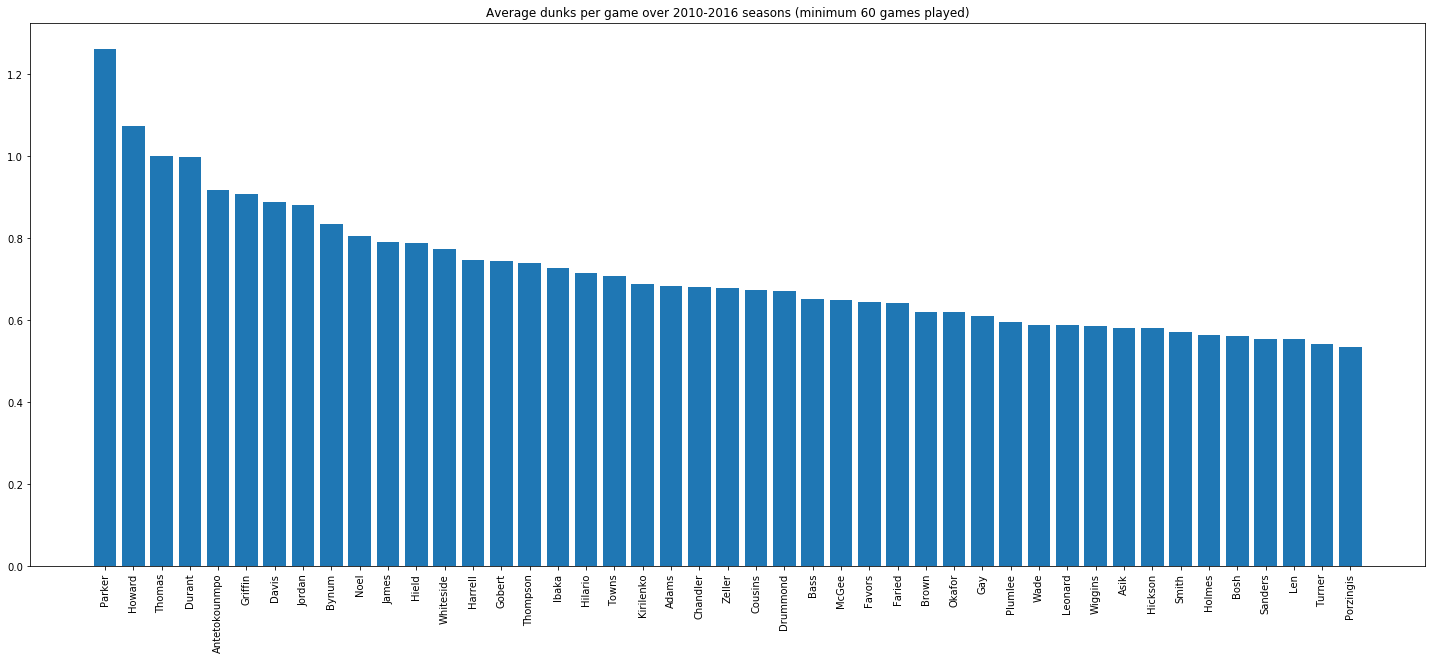

In [699]:
plt.figure(figsize=(25,10))
ax = plt.subplot(111)
ax.bar(np.arange(0,45),dpg_df["dpg"][:45], tick_label =dpg_df["last_name"][:45])
ax.set_xticklabels(dpg_df["last_name"][:45], rotation=90)
ax.set_title("Average dunks per game over 2010-2016 seasons (minimum 60 games played)")

In [ ]:
# Let's look at LeBron James's dunks per game over the last six years.

In [700]:
for i in np.arange(len(group_player_stat_dunks)):
    years = np.arange(2010, 2017)
    year = years[i]
    df = group_player_stat_dunks[i]
    df.index = df.index + "_" + str(year)
    df = df.apply(lambda x: pd.to_numeric(x, errors="ignore"))

In [703]:
lbjstats = []
for df in group_player_stat_dunks:
    lbjstats.append(df[df["first_name"] == "LeBron"])
lbj_yearly_stats_df = pd.concat(lbjstats)

<Container object of 7 artists>

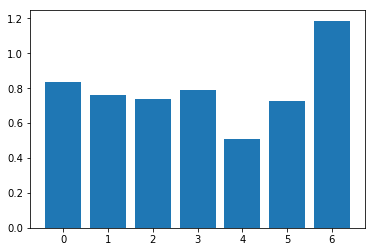

In [704]:
plt.bar(np.arange(len(lbj_yearly_stats_df)), lbj_yearly_stats_df["dpg"])

In [705]:
dwadestats = []
for df in group_player_stat_dunks:
    dwadestats.append(df[df["last_name"] == "Wade"])
dwade_yearly_stats_df = pd.concat(dwadestats)

<Container object of 7 artists>

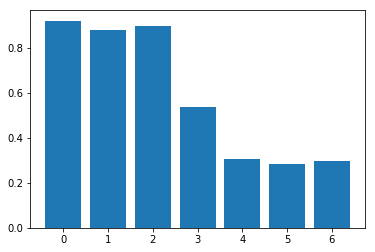

In [725]:
plt.bar(np.arange(len(dwade_yearly_stats_df)), dwade_yearly_stats_df["dpg"])

In [815]:
players = ["LeBron James", "Karl-Anthony Towns", "Kyrie Irving", "Tyson Chandler", "Dwight Howard"]

In [819]:
dunker_ids = [getPlayerId(player.split(" ")[1], player.split(" ")[0], pd.concat(group_player_stat_dunks)) for player in players]

searching for: LeBron James
found: jamesle01_2010
searching for: Karl-Anthony Towns
found: townska01_2015
searching for: Kyrie Irving
found: irvinky01_2011
searching for: Tyson Chandler
found: chandty01_2010
searching for: Dwight Howard
found: howardw01_2010


In [823]:
dunks_by_players = [yearly_dpg_for_player(group_player_stat_dunks, dunker) for dunker in dunker_ids]

KeyError: False

In [822]:
def yearly_dpg_for_player(dfs, dunker_id):
    dpg_by_year = []
    for df in dfs:
        dpg_by_year.append(df["dunker_id" == dunker_id])
    return pd.concat(dpg_by_year)

In [806]:
def plot_dpg(dfs, plot_type="bar"):
    for df in dfs
        first_name, last_name = (df["first_name"][0], df["last_name"][0])
        ax = plt.subplot(111)
        if plot_type == "bar":
            ax.bar(np.arange(len(df.index)), df["dpg"], tick_label = [ix.split("_")[1] for ix in df.index])
        elif plot_type == "line":
            ax.plot(np.arange(len(df.index)), df["dpg"])
            ax.xaxis.set_ticklabels([x.split("_")[1] for x in df.index])
            ax.xaxis.set_ticks(np.arange(len(df.index)))
            ax.set_ylim(bottom=0)
        ax.set_ylabel("Dunks per Game")
        ax.set_xlabel("Season")
        ax.set_title(first_name+" "+last_name)

In [ ]:
plot_dpg()

In [747]:
group_player_stat_dunks[5][group_player_stat_dunks[5]["first_name"] == "Giannis"]["last_name"]

antetgi01_2015    Antetokounmpo
Name: last_name, dtype: object

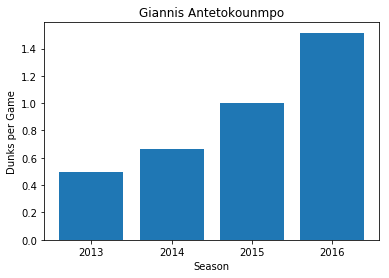

In [800]:
plot_dpg(yearly_dpg_for_player(group_player_stat_dunks, "Giannis", "Antetokounmpo"))

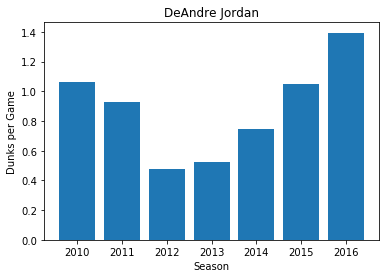

In [761]:
plot_dpg(yearly_dpg_for_player(group_player_stat_dunks, "DeAndre", "Jordan"))

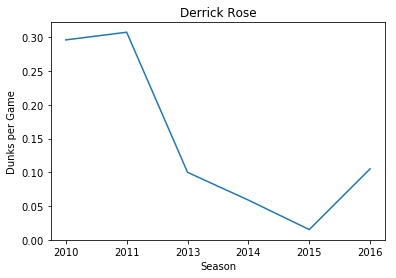

In [808]:
plot_dpg(yearly_dpg_for_player(group_player_stat_dunks, "Derrick", "Rose"), plot_type="line")

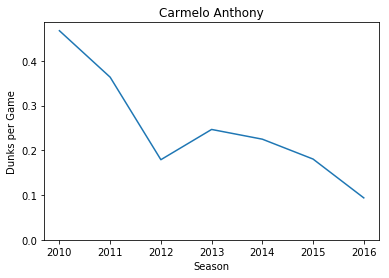

In [809]:
plot_dpg(yearly_dpg_for_player(group_player_stat_dunks, "Carmelo", "Anthony"), plot_type="line")

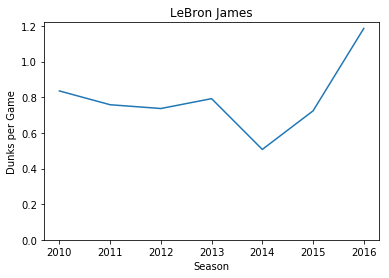

In [810]:
plot_dpg(yearly_dpg_for_player(group_player_stat_dunks, "LeBron", "James"), plot_type="line")

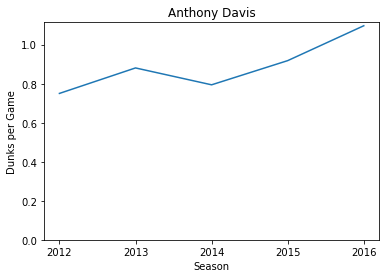

In [811]:
plot_dpg(yearly_dpg_for_player(group_player_stat_dunks, "Anthony", "Davis"), plot_type="line")

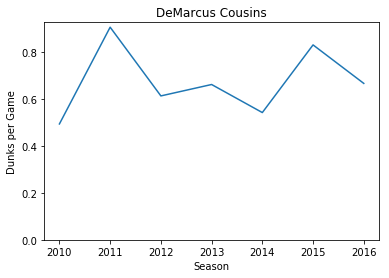

In [812]:
plot_dpg(yearly_dpg_for_player(group_player_stat_dunks, "DeMarcus", "Cousins"), plot_type="line")

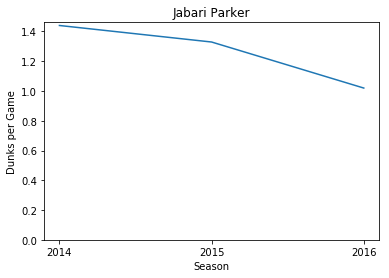

In [814]:
plot_dpg(yearly_dpg_for_player(group_player_stat_dunks, "Jabari", "Parker"), plot_type="line")

In [541]:
top_dunkers = []
for df in group_player_stat_dunks:
    top_dunkers.append(df.ix[:20,:].copy())

In [542]:
group_player_stat_dunks[0].columns

Index([u'age', u'ast', u'blk', u'drb', u'efg_pct', u'fg', u'fg2', u'fg2_pct',
       u'fg2a', u'fg3', u'fg3_pct', u'fg3a', u'fg_pct', u'fga', u'first_name',
       u'ft', u'ft_pct', u'fta', u'g', u'gs', u'last_name', u'mp', u'orb',
       u'pf', u'pos', u'pts', u'stl', u'teams', u'tov', u'trb', u'make',
       u'miss', u'dunk_pct', u'dpg'],
      dtype='object')

In [547]:
years = np.arange(2010, 2017)
for i in np.arange(len(top_dunkers)):
    df = top_dunkers[i]
    year = years[i]
    df.index = df.index + "_" + str(year)

In [554]:
grouped_top_dunkers = pd.concat(top_dunkers)

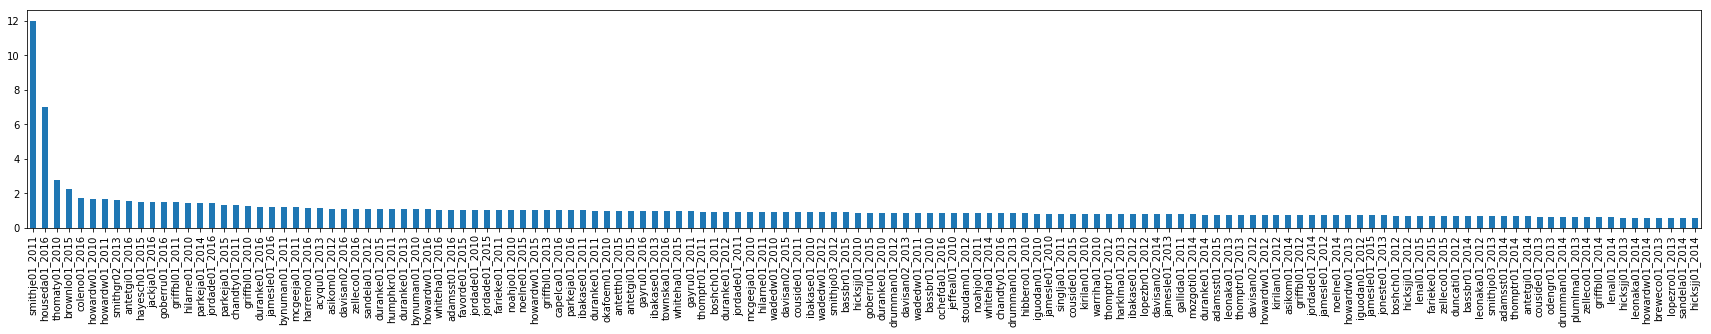

In [573]:
ax = grouped_top_dunkers.sort_values("dpg", ascending=False)["dpg"].plot("bar", figsize=(30, 4))

In [578]:
grouped_top_dunkers = grouped_top_dunkers.apply(lambda x: pd.to_numeric(x, errors="ignore"))

In [581]:
grouped_top_dunkers = grouped_top_dunkers[grouped_top_dunkers["g"] > 20]

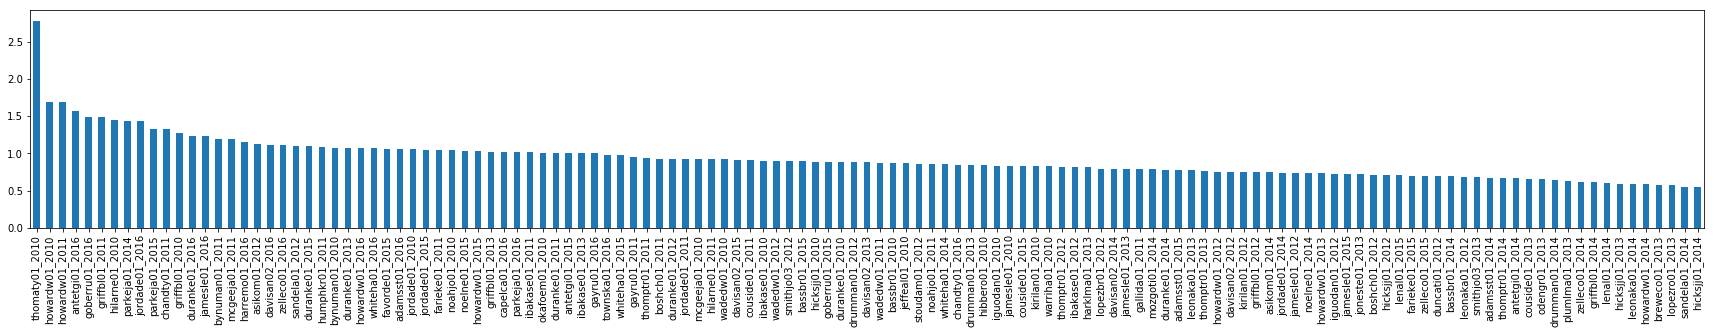

In [582]:
grouped_top_dunkers.sort_values("dpg", ascending=False)["dpg"].plot("bar", figsize=(30, 4))

In [583]:
grouped_top_dunkers

,age,ast,blk,drb,efg_pct,fg,fg2,fg2_pct,fg2a,fg3,...,pos,pts,stl,teams,tov,trb,make,miss,dunk_pct,dpg
thomaty01_2010,24,29,66,159,0.471,156,156,0.476,328,0,...,C,419,30,[CHA],65,224,114.0,7.0,0.942149,2.780488
howardw01_2010,25,107,186,789,0.593,619,619,0.597,1037,0,...,C,1784,107,[ORL],279,1098,132.0,4.0,0.970588,1.692308
hilarne01_2010,28,149,73,426,0.615,402,401,0.618,649,1,...,C,1091,84,[DEN],134,571,109.0,6.0,0.947826,1.453333
griffbl01_2010,21,312,45,719,0.508,696,689,0.510,1352,7,...,PF,1845,63,[LAC],223,989,104.0,13.0,0.888889,1.268293
bynuman01_2010,23,73,106,338,0.574,237,237,0.574,413,0,...,C,612,19,[LAL],74,508,58.0,2.0,0.966667,1.074074
jordade01_2010,22,42,142,368,0.686,234,234,0.688,340,0,...,C,566,41,[LAC],101,575,85.0,11.0,0.885417,1.062500
noahjo01_2010,25,107,72,316,0.525,211,211,0.526,401,0,...,C,561,48,[CHI],90,498,50.0,3.0,0.943396,1.041667
okafoem01_2010,28,42,127,454,0.573,300,300,0.574,523,0,...,C,745,40,[NOH],119,684,72.0,5.0,0.935065,1.000000
mcgeeja01_2010,23,38,193,411,0.550,332,332,0.552,601,0,...,C,798,41,[WAS],102,634,73.0,5.0,0.935897,0.924051
wadedw01_2010,29,346,87,362,0.523,692,629,0.534,1178,63,...,SG,1941,111,[MIA],237,485,70.0,10.0,0.875000,0.921053


In [548]:
stats_dunks_dfs[0]

,age,ast,blk,drb,efg_pct,fg,fg2,fg2_pct,fg2a,fg3,...,trb,dunker_id,assister_id,date,game_id,make,quarter,team,time,id
0,25,168,31,206,.581,312,207,.546,379,105,...,251,afflaar01,wrighdo01,2010-11-13,301113015,1,3,GS,00:05:01,3011130153000501
1,25,168,31,206,.581,312,207,.546,379,105,...,251,afflaar01,curryst01,2010-11-21,301121013,1,1,GS,00:03:06,3011210131000306
2,25,168,31,206,.581,312,207,.546,379,105,...,251,afflaar01,curryst01,2010-12-05,301205025,1,3,GS,00:02:51,3012050253000251
3,25,168,31,206,.581,312,207,.546,379,105,...,251,afflaar01,feltora01,2011-02-28,310228007,1,4,DEN,00:00:25,3102280074000025
4,25,168,31,206,.581,312,207,.546,379,105,...,251,afflaar01,linje01,2011-04-13,310413009,1,4,GS,00:08:33,3104130094000833
5,22,10,19,61,.489,59,47,.475,99,12,...,78,ajincal01,NaN,2010-12-07,301207006,0,2,DAL,00:09:11,3012070062000911
6,22,10,19,61,.489,59,47,.475,99,12,...,78,ajincal01,derozde01,2011-01-26,310126028,1,2,TOR,00:03:25,3101260282000325
7,22,10,19,61,.489,59,47,.475,99,12,...,78,ajincal01,caldejo01,2011-02-23,310223028,1,2,TOR,00:01:12,3102230282000112
8,22,10,19,61,.489,59,47,.475,99,12,...,78,ajincal01,derozde01,2011-03-04,310304017,1,2,TOR,00:08:56,3103040172000856
9,22,10,19,61,.489,59,47,.475,99,12,...,78,ajincal01,NaN,2011-03-26,310326012,0,3,TOR,00:03:12,3103260123000312


In [549]:
all_dunks[0]

,assister_id,date,dunker_id,game_id,make,quarter,team,time,id,miss
0,rondora01,2010-10-26,onealsh01,301026002,1,1,BOS,00:06:43,3010260021000643,0.0
1,NaN,2010-10-26,boshch01,301026002,1,1,MIA,00:06:13,3010260021000613,0.0
2,garneke01,2010-10-26,robinna01,301026002,1,2,BOS,00:06:33,3010260022000633,0.0
3,NaN,2010-10-26,wadedw01,301026002,1,2,MIA,00:05:58,3010260022000558,0.0
4,houseed01,2010-10-26,jamesle01,301026002,1,2,MIA,00:00:52,3010260022000052,0.0
5,rondora01,2010-10-26,davisgl01,301026002,1,4,BOS,00:08:29,3010260024000829,0.0
6,hillgr01,2010-10-26,richaja01,301026022,1,1,PHX,00:07:58,3010260221000758,0.0
7,nashst01,2010-10-26,richaja01,301026022,1,1,PHX,00:01:37,3010260221000137,0.0
8,fryech01,2010-10-26,warriha01,301026022,1,1,PHX,00:00:07,3010260221000007,0.0
9,johnsar02,2010-10-26,matthwe02,301026022,1,2,POR,00:09:36,3010260222000936,0.0


In [550]:
stats_dunks_dfs

[     age  ast blk  drb efg_pct   fg  fg2 fg2_pct  fg2a  fg3        ...         \
 0     25  168  31  206    .581  312  207    .546   379  105        ...          
 1     25  168  31  206    .581  312  207    .546   379  105        ...          
 2     25  168  31  206    .581  312  207    .546   379  105        ...          
 3     25  168  31  206    .581  312  207    .546   379  105        ...          
 4     25  168  31  206    .581  312  207    .546   379  105        ...          
 5     22   10  19   61    .489   59   47    .475    99   12        ...          
 6     22   10  19   61    .489   59   47    .475    99   12        ...          
 7     22   10  19   61    .489   59   47    .475    99   12        ...          
 8     22   10  19   61    .489   59   47    .475    99   12        ...          
 9     22   10  19   61    .489   59   47    .475    99   12        ...          
 10    22   10  19   61    .489   59   47    .475    99   12        ...          
 11    22   10  

In [366]:
player_total_df = all_dunks_df.groupby("dunker_id").sum()

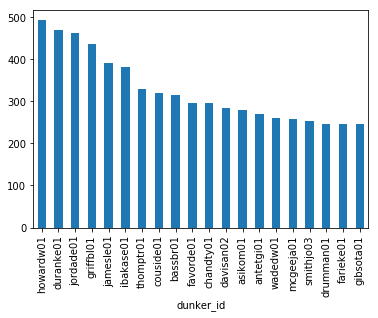

In [374]:
player_total_df.sort_values("make", ascending=False).ix[:20,"make"].plot("Bar")

In [37]:
dunks_2012_player_total["player_id"] = dunks_2012_player_total.index

In [38]:
dunk_stat_2012 = pd.merge(dunks_2012_player_total, player_list, on="player_id")

In [40]:
dunk_stat_2012.columns

Index([u'game_id', u'make', u'quarter', u'id', u'player_id', u'age', u'ast',
       u'blk', u'drb', u'efg_pct', u'fg', u'fg2', u'fg2_pct', u'fg2a', u'fg3',
       u'fg3_pct', u'fg3a', u'fg_pct', u'fga', u'first_name', u'ft', u'ft_pct',
       u'fta', u'g', u'gs', u'last_name', u'mp', u'orb', u'pf', u'pos', u'pts',
       u'stl', u'teams', u'tov', u'trb'],
      dtype='object')

In [41]:
dunk_stat_2012["dpg"] = dunk_stat_2012.make/dunk_stat_2012.g

In [54]:
%matplotlib inline
ordered_dunk_stat_2012 = dunk_stat_2012.loc[:,["dpg", "player_id"]].sort_values("dpg", ascending=False)

<Container object of 352 artists>

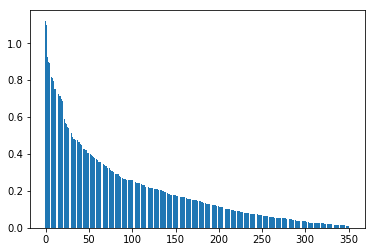

In [55]:
plt.figure()
plt.bar(np.arange(len(ordered_dunk_stat_2012)), ordered_dunk_stat_2012.dpg, )

In [8]:
def date_to_season(row):
    try:
        year = datetime.datetime.strptime(row["date"], "%Y-%m-%d").year
        month = datetime.datetime.strptime(row["date"], "%Y-%m-%d").month
        if month < 10:
            season = year - 1
        else: 
            season = year
        return season
    except TypeError:
        return np.NaN

In [9]:
all_dunks_df["season"] = all_dunks_df.apply(lambda x: date_to_season(x), axis=1)

In [10]:
pivot = all_dunks_df.pivot_table(["make"],["dunker_id","season"],aggfunc=np.sum)

In [11]:
pivot.loc["lopezbr01", :]

,make
season,
2012.0,59.0
2013.0,8.0
2014.0,15.0
2015.0,36.0
2016.0,30.0


In [ ]:
all_dunks_df.groupby("dunker_id").sum().sort("make", ascending=False)

In [ ]:
dunks_2015.groupby("dunker_id").sum().sort("make", ascending=False)

In [ ]:
dunks.groupby("dunker_id").sum().sort("make", ascending=False)

In [ ]:
for col in all_dunks_df.columns:
    try:
        print col, dunks[dunks[col].isnull()]
    except:
        print col

In [ ]:
dunks.loc[[1408,1409,1410], "date"] = datetime.datetime.strptime("December 22, 2013", "%B %d, %Y")

In [ ]:
dunks[dunks.game_id == 400489277]

In [ ]:
dunks.loc[2826, "make"] = 1

In [ ]:
dunks.loc[2826, "dunker_id"] = "howardw01"

In [ ]:
with open(os.path.join("2013/", "dunks.csv"), "wb") as f:
    dunks.to_csv(f)

In [ ]:
import matplotlib.pyplot as plt

ordered_dunks = dunks.groupby("dunker_id").sum().sort("make", ascending=False)

In [ ]:
%matplotlib inline
ordered_dunks[:20].make.plot.bar()

In [ ]:
ordered_dunks

In [ ]:
import uni

In [7]:
import dataset
db = dataset.connect("sqlite:///dunks.db")
table = db["dunks"]

results = table.all()
results = list(results)
len(results)

91174

In [16]:
len(np.unique([result["game_id"] for result in table.find(season=2012)]))

1121

In [8]:
np.unique([result["season"] for result in results])

array([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016])

In [52]:
players = db["players"]

In [54]:
len(list(players.all()))

6911

In [29]:
pd

<module 'pandas' from '//anaconda/envs/python2/lib/python2.7/site-packages/pandas/__init__.pyc'>

In [47]:
df = pd.DataFrame({'ints': [u'3', u'5'], 'Words': ['Kobe', 'Bryant']})
df.apply(pd.to_numeric, errors='ignore').loc[:,'ints']

0    3
1    5
Name: ints, dtype: int64

In [56]:
list(players.find(season=2008))[:5]

[OrderedDict([('id', 3165),
              ('fg2a', 7),
              ('last_name', u'Acker'),
              ('gs', 0),
              ('fg_pct', 0.364),
              ('pos', u'SG'),
              ('fg2', 4),
              ('fg3', 0),
              ('player_id', u'ackeral01'),
              ('pts', 9),
              ('first_name', u'Alex'),
              ('efg_pct', 0.364),
              ('tov', 0),
              ('fta', 2),
              ('pf', 0),
              ('blk', 1),
              ('ft_pct', 0.5),
              ('fg3a', 4),
              ('ft', 1),
              ('ast', 1),
              ('fg3_pct', 0.0),
              ('fg', 4),
              ('orb', 0),
              ('fga', 11),
              ('g', 7),
              ('stl', 2),
              ('age', 26),
              ('trb', 2),
              ('teams', u'DET,LAC'),
              ('fg2_pct', 0.5710000000000001),
              ('mp', 20),
              ('drb', 2),
              ('season', 2008)]),
 OrderedDict([('id', 3166),
 

In [64]:
list(db['games'].all())[-5:]

[OrderedDict([('id', 400278946), ('season', 2012)]),
 OrderedDict([('id', 400278947), ('season', 2012)]),
 OrderedDict([('id', 400278948), ('season', 2012)]),
 OrderedDict([('id', 400278949), ('season', 2012)]),
 OrderedDict([('id', 400278950), ('season', 2012)])]

In [67]:
db['games'].close()

AttributeError: 'Table' object has no attribute 'close'

In [68]:
db.commit()